# anthracene

Look at serial code profiled timings
Compare this to parallel code profiled timings



In [19]:
%load_ext autoreload
%autoreload 2

import json
import textwrap

from isdfbenchmarks.submission import remote


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Remote instance
mpsd_remote = remote.Remote("bucchera", "mpsd-hpc-login1.desy.de", venv="/home/bucchera/programs/isdfBenchmarks/.venv")

In [21]:
# Execute parser on remote, and stream data back

code = textwrap.dedent(r"""
import json

from isdfbenchmarks.parser.profiling import parse_time
from isdfbenchmarks.parser.parse_dir import parse_file_instances


cumulative, self = parse_time("/home/bucchera/exchange_calcs/isdf/24_anthracene/profiling/time.000000")
results = {'cumulative': cumulative, 'self':self}
print(json.dumps(results))
""")

stdout = mpsd_remote.execute_script(code)
results = json.loads(stdout)

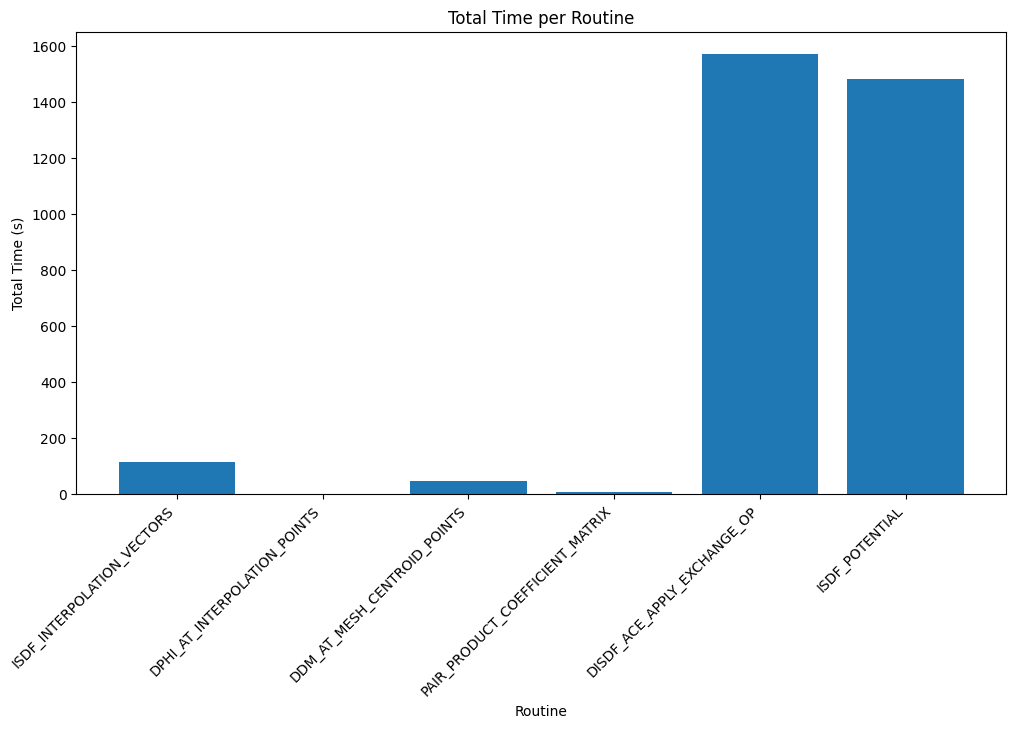

In [24]:
""" Call hierarchy
isdf_interpolation_vectors             -> isdf_interpolation_vectors
	dphi_at_interpolation_points       -> dphi_at_interpolation_points
	dquasi_density_matrix_at_mesh_centroid_points   -> ddm_at_mesh_centroid_points
	pair_product_coefficient_matrix    -> pair_product_coefficient_matrix
disdf_ace_apply_exchange_op            -> disdf_ace_apply_exchange_op  
	isdf_potential                     -> isdf_potential 
	Rest of it   
	
Operations not wrapped for timing:
    P_mu_nu = [psi_ist_mu]^T @ psi_ist_nu
    lalg_svd_inverse
    call symmetrize_matrix(n_int_g, cct)
    ! zeta = [ZC^T][CC^T]^-1
    Kmeans
"""
import matplotlib.pyplot as plt


cumulative_times = results['cumulative']
self_times = results['self']


# Extract times of relevant routines
routines = ['ISDF_INTERPOLATION_VECTORS',
            'DPHI_AT_INTERPOLATION_POINTS',
            'DDM_AT_MESH_CENTROID_POINTS',
            'PAIR_PRODUCT_COEFFICIENT_MATRIX',
            'DISDF_ACE_APPLY_EXCHANGE_OP',
            'ISDF_POTENTIAL']


time_per_call = [cumulative_times[name]['TIME_PER_CALL'] for name in routines]
total_time = [cumulative_times[name]['TOTAL_TIME'] for name in routines]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(routines, total_time)
plt.xlabel('Routine')
plt.ylabel('Total Time (s)')
plt.title('Total Time per Routine')
plt.xticks(rotation=45, ha='right')
plt.show()
